# Regression with Random Forest & Amazon SageMaker XGBoost algorithm

---

### Introduction

The best way to learn how to use Amazon SageMaker is to create, train, and deploy a simple machine learning model. 

To do this, you need the following:

1. **A dataset**. We will use [KaggleDatasets : Housing prices in King County,Seattle US](https://www.kaggle.com/harlfoxem/housesalesprediction). This dataset contains house sale prices for King County in Seattle, sold between May 2014 and May 2015.It's a great dataset for evaluating simple regression models.

2. **An algorithm**. We will use the Random Forest algorithm in scikit-learn and XGBoost Algorithm provided by Amazon SageMaker to train the model using the housing dataset and predict the prices.

You also need a few resources for storing your data and running the code in this notebook:

1. An **Amazon Simple Storage Service (Amazon S3) bucket** to store the training data and the model artifacts that Amazon SageMaker creates when it trains the model.

2. An **Amazon SageMaker notebook** instance to prepare and process data and to train and deploy a machine learning model.

3. A **Jupyter notebook** to use with the notebook instance to prepare your training data and train and deploy the model.

**Important**

To train, deploy, and validate a model in Amazon SageMaker, you can use one of these methods:

    1. Amazon SageMaker Python SDK.
    2. AWS SDK for Python (Boto 3).
          
### Amazon Sagemaker Python SDK vs AWS SDK for Python(Boto 3)

The Amazon SageMaker Python SDK abstracts several implementation details, and is easy to use. If you're a first-time Amazon SageMaker user, aws recommends that you use it to train, deploy, and validate the model.

On the other hand, Boto 3 is the Amazon Web Services (AWS) SDK for Python. It enables Python developers to create, configure, and manage AWS services, such as EC2 and S3. Boto provides an easy to use, object-oriented API, as well as low-level access to AWS services.

Today we will learn how to create all of the resources that you need to train, and deploy a model using **Amazon Sagemaker Python SDK**.

The steps include:

1. Fetching the dataset.
2. Explore and Transform the Training Data so that it can be fed to Amazon SageMaker algorithms.
    1. Feature Engineering and Data Visualizations.
    2. Prepare the data.
    3. Data Ingestion.
3. Train a Model.
    1. Launching a training job with the Python SDK.        
4. Deploy the Model to Amazon SageMaker.
5. Validate the Model.
6. Integrating Amazon SageMaker Endpoints into Internet-facing Applications.
7. Clean up
    

## Decision Tree

- A decision tree is built top-down from a root node and involves partitioning the data into subsets that contain instances with similar values (homogenous).

- Decision tree builds regression or classification models in the form of a tree structure. 




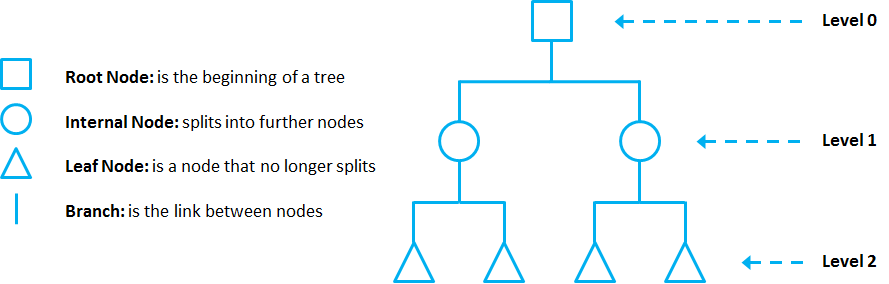

![image](https://github.com/SriramyaK/My-WiMLDS-Minneapolis-Talks/blob/master/WiMLDS/0_cant-HQdfMju-GxG.gif?raw=true)
*Source : Diego Lopez Yse(Apr 17, 2019). Decision tree. Retrieved from Medium: https://towardsdatascience.com/the-complete-guide-to-decision-trees-28a4e3c7be14*

In bidimensional terms (using only 2 variables), DTs partition the data universe into a set of rectangles, and fit a model in each one of those rectangles. They are simple yet powerful, and a great tool for data scientists.

### Fable of blind men and elephant

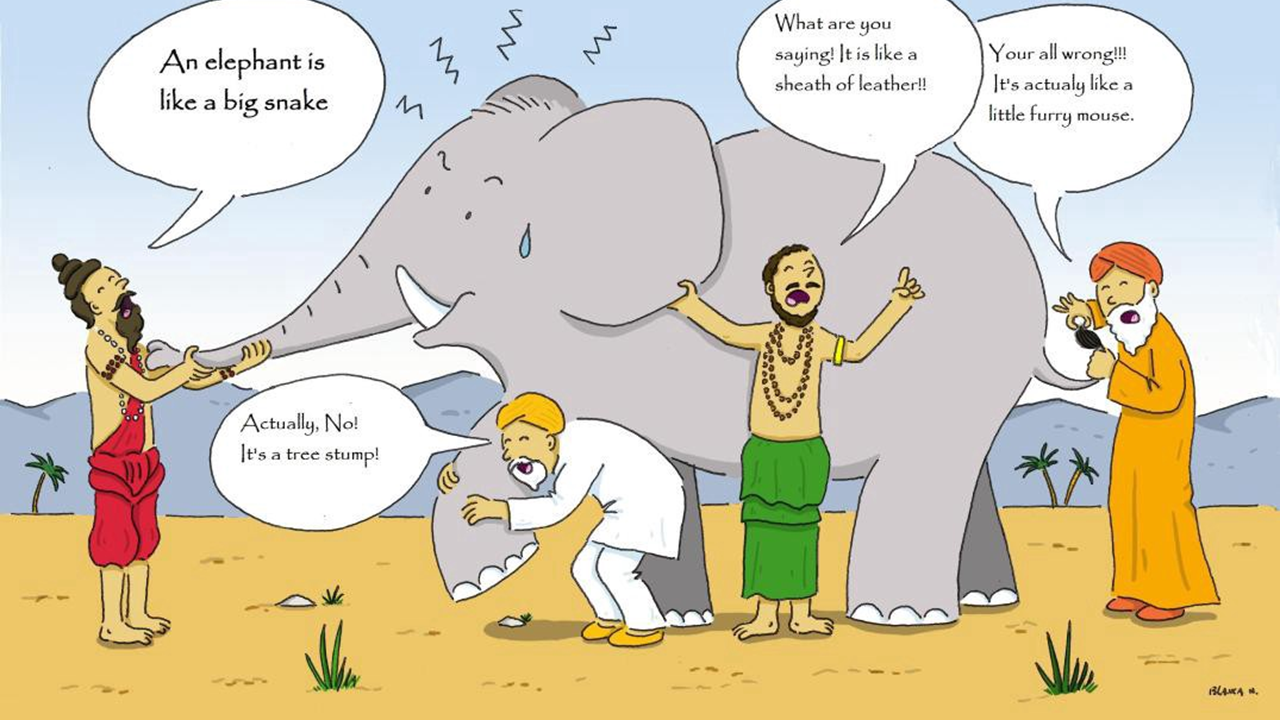

Source: Jinde Shubham.(Jul 3, 2018). Ensemble learning is Fable of blind men and elephant. Retrieved from Medium :https://becominghuman.ai/ensemble-learning-bagging-and-boosting-d20f38be9b1e

### Wisdom of the Crowd 

A random forest is an example of an ensemble, which is a combination of predictions from different models. In an ensemble, predictions could be combined either by majority-voting or by taking averages. Below is an illustration of how an ensemble formed by majority-voting yields more accurate predictions than the individual models it is based on:

![RandomForest](https://github.com/SriramyaK/My-WiMLDS-Minneapolis-Talks/blob/master/WiMLDS/ensemble.gif?raw=true)  
*Source : Annalyn Ng and Kenneth Soo (July 27, 2016). How a tree is created in a random forest. Retrived from algobeans.com: https://algobeans.com/2016/07/27/decision-trees-tutorial/*

## Random Forest

In random forest, bagging is used to create thousands of decision trees with minimal correlation. In bagging, a random subset of the training data is selected to train each tree. Furthermore, the model randomly restricts the variables which may be used at the splits of each tree. Hence, the trees grown are dissimilar, but they still retain certain predictive power.


![RandomForest](https://annalyzin.files.wordpress.com/2016/08/bagging.gif?w=620)

In the above example, there are 9 variables represented by 9 colors. At each split, a subset of variables is randomly sampled from the original 9. Within this subset, the algorithm chooses the best variable for the split. The size of the subset was set to the square root of the original number of variables. Hence, in our example, this number is 3.

*Source : Annalyn Ng and Kenneth Soo (July 27, 2016). Wisdom of crowd . Retrived from algobeans.com: https://algobeans.com/2016/07/27/decision-trees-tutorial/*

### Fetching the dataset

In [9]:
import pandas as pd # library for data manipulation and analysis.
import numpy as np # library for scientific computing, provides high-performance, easy to use structures and data analysis tools. 
import matplotlib.pyplot as plt # Plotting library
import seaborn as sns # data visualization library
sns.set(style="darkgrid")

data = pd.read_csv("kc_house_data.csv", parse_dates=['date'])

### Explore and Transform the Training Data so that it can be fed to Amazon SageMaker algorithms.

Let's start exploring the data. First, let's understand how the features are distributed and check if they have any missing values.

In [10]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null datetime64[ns]
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(15)
memory usage: 3.5 MB


In [12]:
data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,2014-10-15,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [13]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


#### Feature Engineering and Data Visualizations:

Next, let's look at how our features relate to the target that we are attempting to predict.

In [14]:
#data['years_renovated'] = data['yr_renovated'] - data['yr_built']

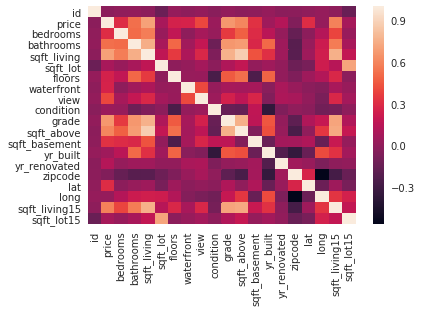

In [15]:
numeric_data = ['id','price','bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']
numeric_analysis = pd.DataFrame(data[numeric_data]).corr()
sns.heatmap(numeric_analysis)

In [16]:
attributes = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']

y_data = data['price']
x_data = data [attributes]

#### Preparing the data

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=1)

In [18]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((17290, 18), (4323, 18), (17290,), (4323,))

In [19]:
x_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7291,3,1.75,2190,7021,1.0,0,2,4,7,1390,800,1953,0,98178,47.5033,-122.232,2180,7155
14835,3,2.50,2370,6840,2.0,0,0,3,9,2370,0,1987,0,98119,47.6503,-122.366,1590,4400
15880,2,1.00,1230,3800,1.0,0,0,3,7,1230,0,1928,0,98115,47.6797,-122.292,1610,3800
8812,4,2.25,2510,9963,1.0,0,0,4,9,2200,310,1967,0,98005,47.5973,-122.177,3110,9963
17220,3,1.00,1160,7491,1.0,0,0,4,6,1160,0,1917,0,98177,47.7024,-122.359,1800,2267


In [20]:
trainX = pd.DataFrame(x_train, columns=attributes)
trainX['target'] = y_train

testX = pd.DataFrame(x_test, columns=attributes)
testX['target'] = y_test

In [21]:
trainX.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,target
7291,3,1.75,2190,7021,1.0,0,2,4,7,1390,800,1953,0,98178,47.5033,-122.232,2180,7155,353000.0
14835,3,2.50,2370,6840,2.0,0,0,3,9,2370,0,1987,0,98119,47.6503,-122.366,1590,4400,300523.0
15880,2,1.00,1230,3800,1.0,0,0,3,7,1230,0,1928,0,98115,47.6797,-122.292,1610,3800,435000.0
8812,4,2.25,2510,9963,1.0,0,0,4,9,2200,310,1967,0,98005,47.5973,-122.177,3110,9963,800000.0
17220,3,1.00,1160,7491,1.0,0,0,4,6,1160,0,1917,0,98177,47.7024,-122.359,1800,2267,417500.0


In [22]:
trainX.to_csv('housing_train.csv')
testX.to_csv('housing_test.csv')

#### Data Ingestion

Now we'll copy the file to S3 for Amazon SageMaker's managed training to pickup.This should be within the same region as the Notebook Instance, training, and hosting.


In [23]:
import datetime
import tarfile

import boto3
from sagemaker import get_execution_role
import sagemaker

m_boto3 = boto3.client('sagemaker')

sess = sagemaker.Session()

region = sess.boto_session.region_name

bucket = sess.default_bucket()  # this could also be a hard-coded bucket name

print('Using bucket ' + bucket)

Using bucket sagemaker-us-east-1-262760754591


In [24]:
# send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
    path='housing_train.csv', bucket=bucket,
    key_prefix='sagemaker/sklearncontainer')

testpath = sess.upload_data(
    path='housing_test.csv', bucket=bucket,
    key_prefix='sagemaker/sklearncontainer')

#### Prepare a Scikit-learn Training Script 

Our Scikit-learn training script must be a Python 2.7 or 3.6 compatible source file.

The training script is similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables. For example:

    - SM_MODEL_DIR:  A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

    - SM_OUTPUT_DATA_DIR: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, ‘train’ and ‘test’, were used in the call to the Scikit-learn estimator’s fit() method, the following will be set, following the format “SM_CHANNEL_[channel_name]”:

    - SM_CHANNEL_TRAIN: A string representing the path to the directory containing data in the ‘train’ channel

    - SM_CHANNEL_TEST: Same as above, but for the ‘test’ channel.
    
[Refer Sagemaker Documentation](https://sagemaker.readthedocs.io/en/stable/using_sklearn.html#prepare-a-scikit-learn-training-script)    

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

The argparse module makes it easy to write user-friendly command-line interfaces. The program defines what arguments it requires, and argparse will figure out how to parse those out of sys.argv. The argparse module also automatically generates help and usage messages and issues errors when users give the program invalid arguments.


For example, a training script might start with the following:

In [25]:
%%writefile script.py

import argparse
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.metrics import explained_variance_score, r2_score



# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

if __name__ =='__main__':

    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    # to simplify the demo we don't use all sklearn RandomForest hyperparameters
    parser.add_argument('--n-estimators', type=int, default=100)
    parser.add_argument('--max_leaf_nodes', type=int, default=10)
    

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--train-file', type=str, default='housing_train.csv')
    parser.add_argument('--test-file', type=str, default='housing_test.csv')
    
    args, _ = parser.parse_known_args()
    
    print('reading data')
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print('building training and testing datasets')
    attributes = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']
    X_train = train_df[attributes]
    X_test = test_df[attributes]
    y_train = train_df['target']
    y_test = test_df['target']
    
    # train
    print('training model')
    model = RandomForestRegressor(
        n_estimators=args.n_estimators,
        max_leaf_nodes =args.max_leaf_nodes,
        n_jobs=-1)
    
    model.fit(X_train, y_train)
     
    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print('model persisted at ' + path)
    
    # print explained_variance_score 
    print('validating model')
    predictions = model.predict(X_test)
    print("Explained Variance Score is " + str(explained_variance_score(y_test, predictions).round(2)))
    print("R2 score : %.2f" % r2_score(y_test,predictions))
  

Writing script.py


## Local Training

Script arguments allows us to remove from the script any SageMaker-specific configuration, and run locally

In [26]:
! python script.py --n-estimators 500 \
                   --max-leaf-nodes 16 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \
                   

extracting arguments
reading data
building training and testing datasets
training model
model persisted at ./model.joblib
validating model
Explained Variance Score is 0.68
R2 score : 0.68


## SageMaker Training - Launching a training job with the Python SDK

### Create an Estimator

You run Scikit-learn training scripts on SageMaker by creating SKLearn Estimators. Call the fit method on a SKLearn Estimator to start a SageMaker training job. The following code sample shows how you train a custom Scikit-learn script named “script.py”, passing in two hyperparameters ('n-estimators', 'max_leaf_nodes'), and using two input channel directories (‘train’ and ‘test’).

In [27]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

sklearn_estimator = SKLearn(
    entry_point='script.py',
    role = get_execution_role(),
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    framework_version='0.20.0',
    base_job_name='rf-scikit',
    hyperparameters = {'n-estimators': 500,
                       'max_leaf_nodes': 16 
                       })

In [28]:
# launch training job, with asynchronous call
sklearn_estimator.fit({'train':trainpath, 'test': testpath}, wait=False)

## Deploy to a real-time endpoint


### Deploy with Python SDK

An Estimator could be deployed directly after training, with an Estimator.deploy() but here we are using the more extensive process of creating a model from s3 artifacts, that could be used to deploy a model that was trained in a different session or even out of SageMaker.

In [29]:
sklearn_estimator.latest_training_job.wait(logs='None')
artifact = m_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name)['ModelArtifacts']['S3ModelArtifacts']

print('Model artifact persisted at ' + artifact)


2020-04-24 21:48:58 Starting - Starting the training job
2020-04-24 21:49:00 Starting - Launching requested ML instances............
2020-04-24 21:50:06 Starting - Preparing the instances for training..........
2020-04-24 21:51:01 Downloading - Downloading input data....
2020-04-24 21:51:27 Training - Downloading the training image...
2020-04-24 21:51:48 Training - Training image download completed. Training in progress....
2020-04-24 21:52:04 Uploading - Uploading generated training model
2020-04-24 21:52:11 Completed - Training job completed
Model artifact persisted at s3://sagemaker-us-east-1-262760754591/rf-scikit-2020-04-24-21-48-57-211/output/model.tar.gz


In [30]:
predictor = sklearn_estimator.deploy(instance_type='ml.m4.xlarge',initial_instance_count=1)

---------------!

### Invoke with the Python SDK

In [31]:
attributes = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']
print(predictor.predict(testX[attributes]))

[ 522866.64815341  468811.93460939  551243.6250504  ...  275341.74809002
 2024476.51824543  459590.25565695]


In [32]:
predictions = predictor.predict(testX[attributes])

In [33]:
from sklearn.metrics import r2_score
print("R2 score : %.2f" % r2_score(testX['target'],predictions))

R2 score : 0.73


### Don't forget to delete the endpoint !

In [34]:
sagemaker.Session().delete_endpoint(predictor.endpoint)
# bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
# bucket_to_delete.objects.all().delete()

## XG Boost Algorithm


Using the best binary question to split the data at the start may not lead to the most accurate predictions. Sometimes, less effective splits used initially may lead to even better predictions subsequently.

To resolve this, we can choose different combinations of binary questions to grow multiple trees, and then use the aggregated prediction of those trees. As we saw earlier this technique as is called a random forest. 

Now, instead of combining binary questions randomly, we can strategically select them, such that the prediction accuracy for each subsequent tree improves incrementally. Then, a weighted average of predictions from all trees is taken. This technique is called gradient boosting.

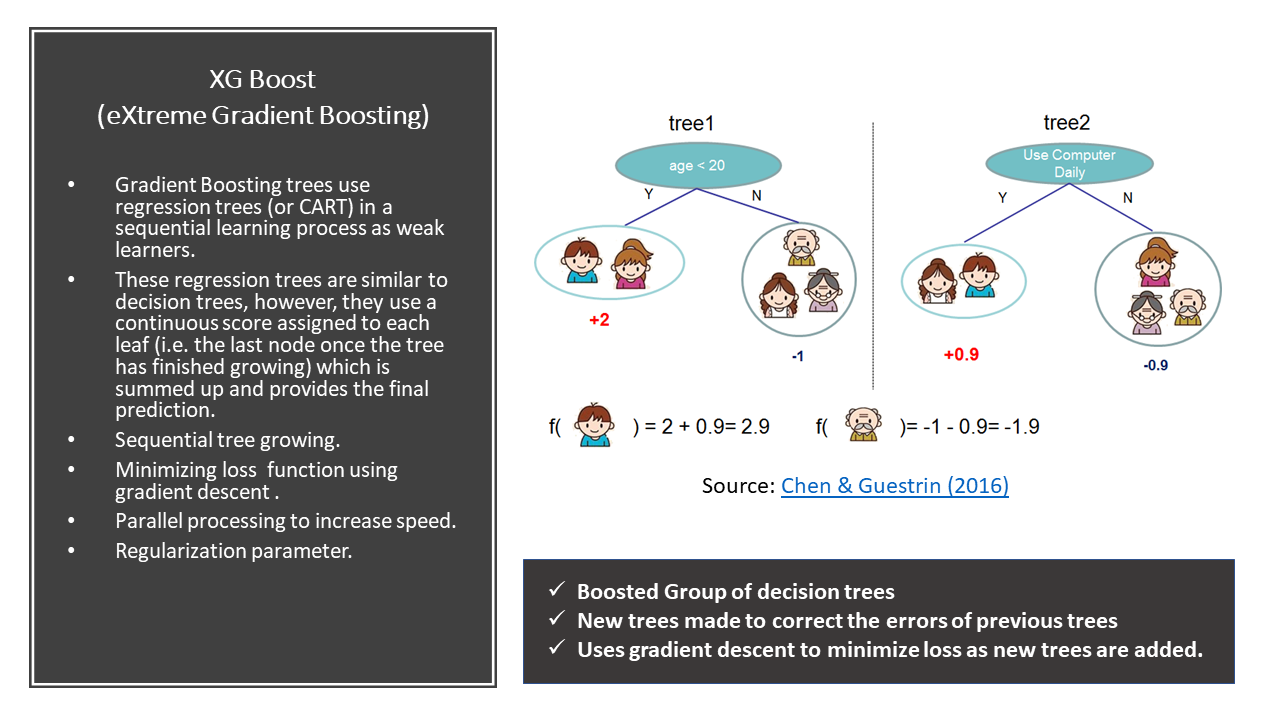

In [35]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Define IAM role and assign S3 bucket
role = get_execution_role()
prefix = 'sagemaker/wimlds-sagemaker-xgboost-demo'
bucket_name = 'sagemaker-us-east-1-262760754591' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET

containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container

my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


### Prepare the data

In [36]:
train_data, test_data = np.split(data.sample(frac=1, random_state=1729), [int(0.7 * len(data))])
print(train_data.shape, test_data.shape)

(15129, 21) (6484, 21)


In [37]:
train_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17399,5153900080,2014-07-14,199000.0,3,1.00,1510,9100,1.0,0,0,...,7,1510,0,1966,0,98003,47.3331,-122.319,1180,7220
16005,2754700095,2015-03-16,747000.0,3,1.50,1710,5120,2.0,0,0,...,7,1710,0,1920,0,98115,47.6801,-122.305,1530,5170
8382,4399200100,2015-04-28,288000.0,3,2.25,1560,9706,1.0,0,0,...,7,1560,0,1963,0,98002,47.3191,-122.213,1510,9706
7381,3897100275,2014-10-27,460000.0,3,1.75,1660,9900,2.0,0,0,...,8,1660,0,1978,0,98033,47.6704,-122.184,1720,6600
16824,9477201470,2014-10-22,379950.0,3,1.00,1270,6900,1.0,0,0,...,7,1270,0,1977,0,98034,47.7279,-122.192,1480,7280


In [38]:
len(train_data.columns)

21

Amazon SageMaker's XGBoost container expects data in the libSVM or CSV data format. For this example, we'll stick to CSV. Note that the first column must be the target variable and the CSV should not include headers. Also, notice that although repetitive it's easiest to do this after the train|validation|test split rather than before. This avoids any misalignment issues due to random reordering.

In [39]:
attributes = ['price','bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15']
len(attributes)

19

In [40]:
train_data = train_data[attributes]

In [41]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train_data = scaler.fit_transform(train_data)
# train_data = pd.DataFrame(train_data)

In [42]:
train_data.to_csv('train.csv', index=False, header=False)

### Upload training data to S3 Bucket

In [43]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

### Training

First we'll need to specify training parameters to the estimator. This includes:

- The xgboost algorithm container
- The IAM role to use
- Training instance type and count
- S3 location for output data
- Algorithm hyperparameters

And then a .fit() function which specifies:

S3 location for output data. In this case we have both a training and validation set which are passed in.

In [44]:
sess = sagemaker.Session()

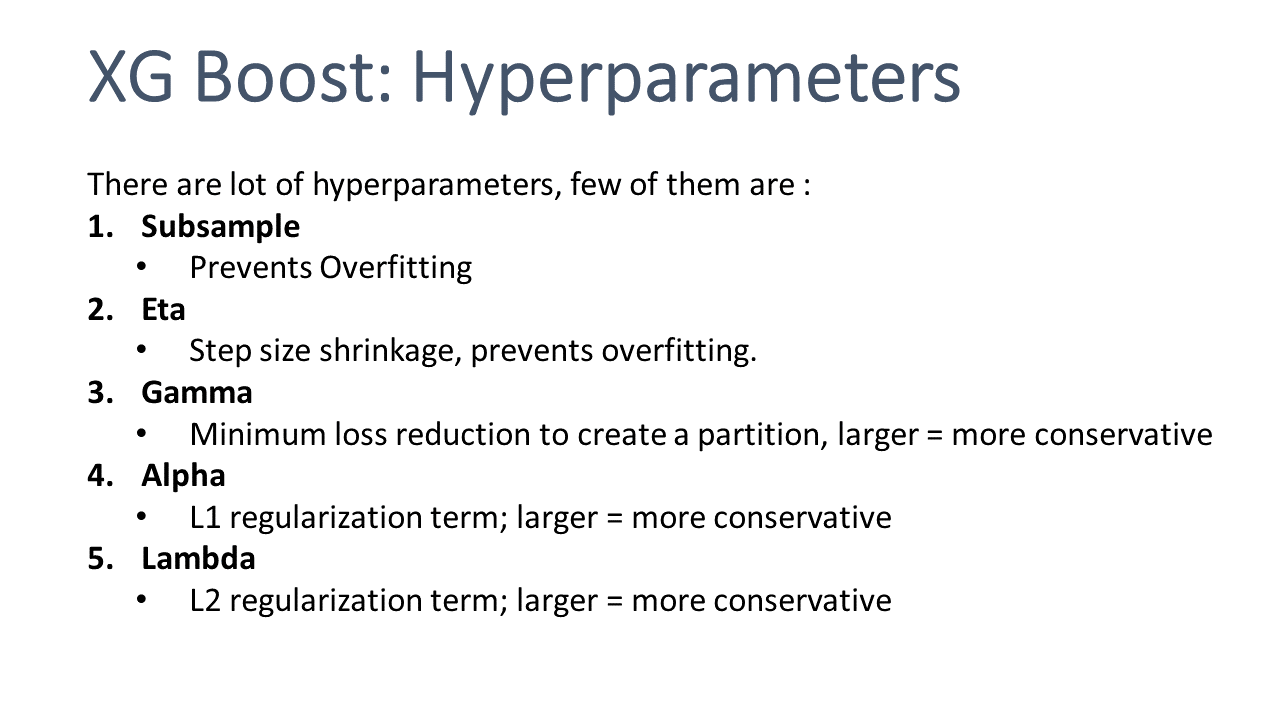

In [45]:
xgb = sagemaker.estimator.Estimator(containers[my_region],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket_name, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(eta=0.06,
                        alpha=0.8,
                        lambda_bias=0.8,
                        gamma=1000,
                        min_child_weight=6,
                        subsample=0.2,
                        silent=0,
                        early_stopping_rounds=5,
                        objective='reg:linear',
                        num_round=1000)
                        

In [46]:
xgb.fit({'train': s3_input_train})

2020-04-24 21:59:48 Starting - Starting the training job...
2020-04-24 21:59:49 Starting - Launching requested ML instances......
2020-04-24 22:00:58 Starting - Preparing the instances for training......
2020-04-24 22:01:55 Downloading - Downloading input data...
2020-04-24 22:02:48 Training - Training image download completed. Training in progress..Arguments: train
[2020-04-24:22:02:49:INFO] Running standalone xgboost training.
[2020-04-24:22:02:49:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-04-24:22:02:49:INFO] File size need to be processed in the node: 1.29mb. Available memory size in the node: 8494.99mb
[2020-04-24:22:02:49:INFO] Determined delimiter of CSV input is ','
[22:02:49] S3DistributionType set as FullyReplicated
[22:02:49] 15129x18 matrix with 272322 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[22:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[0]#011tra

In [47]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

----------------!

In [48]:
test_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9581,5466310730,2014-08-22,165000.0,3,2.50,1660,2415,2.0,0,0,...,7,1660,0,1983,0,98042,47.3763,-122.148,1740,2624
11264,7950303290,2015-04-02,499950.0,3,1.75,2060,3500,1.0,0,0,...,7,1030,1030,1951,0,98118,47.5635,-122.282,1110,6000
15165,3034200660,2014-06-19,507000.0,3,2.50,2120,7201,2.0,0,0,...,8,2120,0,2003,0,98133,47.7174,-122.337,1930,7206
10336,7525300240,2015-02-19,750000.0,4,2.25,2820,9602,1.0,0,1,...,8,1950,870,1974,0,98008,47.5881,-122.113,2890,9602
9861,7805450560,2014-08-20,960000.0,4,2.50,3110,11397,2.0,0,3,...,10,3110,0,1984,0,98006,47.5623,-122.106,3110,11586
6771,5442300807,2014-06-24,2700000.0,5,2.75,3831,13800,2.0,1,4,...,9,3831,0,1959,1980,98040,47.5919,-122.251,3850,36563
16671,9250900104,2014-11-10,300000.0,5,1.75,2110,8500,1.0,0,0,...,7,1100,1010,1962,0,98133,47.7737,-122.350,2020,8500
10849,1446401555,2014-12-08,292000.0,3,1.75,1320,6600,1.0,0,0,...,7,1320,0,1988,0,98168,47.4838,-122.330,1070,6594
17419,6138000095,2014-11-18,219000.0,3,1.00,1080,10639,1.5,0,0,...,7,1080,0,1953,0,98002,47.3171,-122.219,1470,10600
18304,1425039029,2014-09-23,1230000.0,5,4.00,4390,6656,2.0,0,0,...,9,2930,1460,2008,0,98199,47.6480,-122.397,1560,6656


### Evaluation

There are many ways to compare the performance of a machine learning model, but let's start by simply comparing actual to predicted values. 

First we'll need to determine how we pass data into and receive data from our endpoint. Our data is currently stored as NumPy arrays in memory of our notebook instance. To send it in an HTTP POST request, we'll serialize it as a CSV string and then decode the resulting CSV.

Note: For inference with CSV format, SageMaker XGBoost requires that the data does NOT include the target variable.

In [49]:
test_data_array = test_data.drop(['date', 'price','id'], axis=1).values #load the data into an array

In [50]:
test_data_array

array([[ 3.00000e+00,  2.50000e+00,  1.66000e+03, ..., -1.22148e+02,
         1.74000e+03,  2.62400e+03],
       [ 3.00000e+00,  1.75000e+00,  2.06000e+03, ..., -1.22282e+02,
         1.11000e+03,  6.00000e+03],
       [ 3.00000e+00,  2.50000e+00,  2.12000e+03, ..., -1.22337e+02,
         1.93000e+03,  7.20600e+03],
       ...,
       [ 3.00000e+00,  2.50000e+00,  1.24000e+03, ..., -1.22340e+02,
         1.41000e+03,  1.35500e+03],
       [ 3.00000e+00,  2.25000e+00,  1.80000e+03, ..., -1.22013e+02,
         2.73000e+03,  3.64040e+04],
       [ 3.00000e+00,  1.00000e+00,  1.20000e+03, ..., -1.22008e+02,
         1.21000e+03,  8.98500e+03]])

In [51]:
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type


In [52]:
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(6484,)


In [53]:
from sklearn.metrics import r2_score
print("R2 score : %.2f" % r2_score(test_data['price'],predictions_array))

R2 score : 0.87


## Integrating Amazon SageMaker Endpoints into Internet-facing Applications

In a production environment, you might have an internet-facing application sending requests to the endpoint for inference. The following high-level example shows how to integrate your model endpoint into your application.

For an example of how to use Amazon API Gateway and AWS Lambda to set up and deploy a web service that you can call from a client application -

- Create an IAM role that the AWS Lambda service principal can assume. Give the role permissions to call the Amazon SageMaker InvokeEndpoint API.

- Create a Lambda function that calls the Amazon SageMaker InvokeEndpoint API.

- Call the Lambda function from a mobile application.

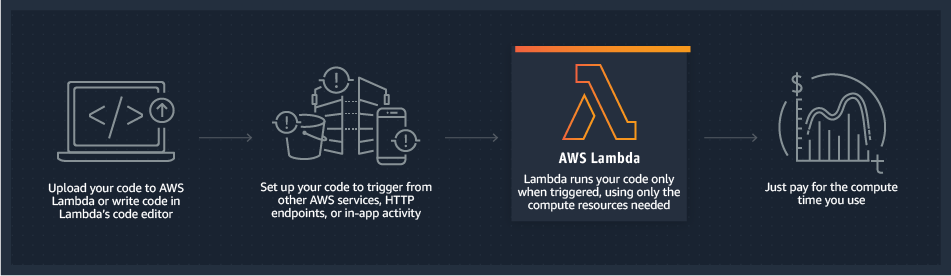

https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/

### Optional Clean-up

If you are done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [56]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

[{'ResponseMetadata': {'RequestId': '98875884920A7407',
   'HostId': 'dr3/tddOnThxXf3TJOYbEYvJehTlU6HEEQbduokto6edbi2n6QO2fVs8AXESf8SSkuuCbAajG08=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'dr3/tddOnThxXf3TJOYbEYvJehTlU6HEEQbduokto6edbi2n6QO2fVs8AXESf8SSkuuCbAajG08=',
    'x-amz-request-id': '98875884920A7407',
    'date': 'Fri, 24 Apr 2020 22:14:14 GMT',
    'connection': 'close',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'sagemaker/sklearncontainer/housing_test.csv'},
   {'Key': 'sagemaker/wimlds-sagemaker-xgboost-demo/train/train.csv'},
   {'Key': 'sagemaker/sklearncontainer/housing_train.csv'},
   {'Key': 'sagemaker/wimlds-sagemaker-xgboost-demo/output/xgboost-2020-04-24-21-59-48-478/output/model.tar.gz'},
   {'Key': 'rf-scikit-2020-04-24-21-48-57-211/debug-output/training_job_end.ts'},
   {'Key': 'rf-scikit-2020-04-24-21-48-57-211/output/model.tar.gz'},
   {

[Amazon Sagemaker Pricing](https://aws.amazon.com/sagemaker/pricing/)

Try Amazon SageMaker for two months, free!

As part of the AWS Free Tier, you can get started with Amazon SageMaker for free. If you have never used Amazon SageMaker before, for the first two months, you are offered a monthly free tier of 250 hours of t2.medium or t3.medium notebook usage for building your models, plus 50 hours of m4.xlarge or m5.xlarge for training, plus 125 hours of m4.xlarge or m5.xlarge for deploying your machine learning models for real-time inferencing and batch transform with Amazon SageMaker. Your free tier starts from the first month when you create your first SageMaker resource.

### References

1. Diego Lopez Yse(Apr 17, 2019). Decision tree. Retrieved from Medium: https://towardsdatascience.com/the-complete-guide-to-decision-trees-28a4e3c7be14

2. Jinde Shubham.(Jul 3, 2018).  Ensemble learning is Fable of blind men and  elephant. Retrieved from Medium :https://becominghuman.ai/ensemble-learning-bagging-and-boosting-d20f38be9b1e

3. Tianqi Chen and Carlos Guestrin. 2016. XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD ’16). Association for Computing Machinery, New York, NY, USA, 785–794. DOI:https://doi.org/10.1145/2939672.2939785

4. Annalyn Ng and Kenneth Soo (July 27, 2016). How a tree is created in a random forest. Retrived from algobeans.com: https://algobeans.com/2016/07/27/decision-trees-tutorial/

5.  AWS SageMaker Screenshots and figures. Retrieved from Amazon Web Services, Inc. : https://docs.aws.amazon.com/sagemaker/#amazon-sagemaker-overview